In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import chi2_contingency
import math

In [2]:
train = pd.read_csv("data/loan_train.csv", delimiter= ",", encoding= "utf-8")
test = pd.read_csv("data/loan_test.csv", delimiter= ",", encoding= "utf-8")

In [3]:
train

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,290000,0.0,7100000,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,410600,0.0,4000000,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,807200,24000.0,25300000,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,758300,0.0,18700000,360.0,1.0,Urban,Y


In [4]:
test

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area
0,Male,Yes,0,Graduate,No,572000,0,11000000,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,307600,150000,12600000,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,500000,180000,20800000,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,234000,254600,10000000,360.0,NaN,Urban
4,Male,No,0,Not Graduate,No,327600,0,7800000,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
362,Male,Yes,3+,Not Graduate,Yes,400900,177700,11300000,360.0,1.0,Urban
363,Male,Yes,0,Graduate,No,415800,70900,11500000,360.0,1.0,Urban
364,Male,No,0,Graduate,No,325000,199300,12600000,360.0,NaN,Semiurban
365,Male,Yes,0,Graduate,No,500000,239300,15800000,360.0,1.0,Rural


# Pré Tratamento Dados

In [5]:
print(train['Dependents'].unique())

['0' '1' '2' '3+' nan]


In [6]:
scaler = MinMaxScaler()

def transform_data (df) : 
    
    df_aux = df.copy()
    
    df_aux['Married'] = np.where(df_aux['Married'] == 'Yes', 1,
        np.where(df_aux['Married'] == 'No', 0, -1)
    )
    
    df_aux['Male'] = np.where(df_aux['Gender'] == 'Male', 1,
        np.where(df_aux['Gender'] == 'Female', 0, -1)
    )
    
    df_aux['Graduate'] = np.where(df_aux['Education'] == 'Graduate', 1, 0)
    
    df_aux['Self_Employed'] = np.where(df_aux['Self_Employed'] == 'Yes', 1,
        np.where(df_aux['Self_Employed'] == 'No', 0, -1)
    )
    
    df_aux['Dependents'] = np.where(df_aux['Dependents'] == '3+', 3, df_aux['Dependents'])
    df_aux['Dependents'] = pd.to_numeric(df_aux['Dependents'], errors='coerce')
    
    df_aux['Term_360'] = np.where(df_aux['Term'] == 360, 1, 0)

    df_aux = df_aux.drop(['Gender', 'Education', 'Term'], axis=1)
    
    #df_aux[['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term']] = scaler.fit_transform(df_aux[['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term']])
    
    return df_aux

In [7]:
train_trat_v1 = transform_data(train)
train_trat_v1['Status'] = np.where(train_trat_v1['Status'] == 'Y', 0, 1)

test_trat_v1 = transform_data(test)

In [8]:
train_trat_v1

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Area,Status,Male,Graduate,Term_360
0,0,0.0,0,584900,0.0,15000000,1.0,Urban,0,1,1,1
1,1,1.0,0,458300,150800.0,12800000,1.0,Rural,1,1,1,1
2,1,0.0,1,300000,0.0,6600000,1.0,Urban,0,1,1,1
3,1,0.0,0,258300,235800.0,12000000,1.0,Urban,0,1,0,1
4,0,0.0,0,600000,0.0,14100000,1.0,Urban,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0.0,0,290000,0.0,7100000,1.0,Rural,0,0,1,1
610,1,3.0,0,410600,0.0,4000000,1.0,Rural,0,1,1,0
611,1,1.0,0,807200,24000.0,25300000,1.0,Urban,0,1,1,1
612,1,2.0,0,758300,0.0,18700000,1.0,Urban,0,1,1,1


# AED

In [9]:
train_trat_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Married             614 non-null    int32  
 1   Dependents          599 non-null    float64
 2   Self_Employed       614 non-null    int32  
 3   Applicant_Income    614 non-null    int64  
 4   Coapplicant_Income  614 non-null    float64
 5   Loan_Amount         614 non-null    int64  
 6   Credit_History      564 non-null    float64
 7   Area                614 non-null    object 
 8   Status              614 non-null    int32  
 9   Male                614 non-null    int32  
 10  Graduate            614 non-null    int32  
 11  Term_360            614 non-null    int32  
dtypes: float64(3), int32(6), int64(2), object(1)
memory usage: 43.3+ KB


In [10]:
train_trat_v1.describe()

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Status,Male,Graduate,Term_360
count,614.000000,599.000000,614.000000,6.140000e+02,6.140000e+02,6.140000e+02,564.000000,614.000000,614.000000,614.000000,614.000000
mean,0.643322,0.762938,0.081433,5.403459e+05,1.621246e+05,1.414104e+07,0.842199,0.312704,0.775244,0.781759,0.833876
std,0.489511,1.015216,0.423472,6.109042e+05,2.926248e+05,8.815682e+06,0.364878,0.463973,0.465767,0.413389,0.372495
min,-1.000000,0.000000,-1.000000,1.500000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.877500e+05,0.000000e+00,9.800000e+06,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,3.812500e+05,1.188500e+05,1.250000e+07,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,0.000000,5.795000e+05,2.297250e+05,1.647500e+07,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,8.100000e+06,4.166700e+06,7.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000


# Tabelas de Frequência

- Variavel Alvo

In [11]:
total_counts = train_trat_v1['Status'].value_counts(normalize=True) * 100
total_counts.round(2)

0    68.73
1    31.27
Name: Status, dtype: float64

- Variavel Married : Frequencia

In [12]:
# Distribuição percentual da coluna 'Married' para a base como um todo
# normalize=True ==> % do Total || normalize=False ==> Contagem 
total_counts = train_trat_v1['Married'].value_counts(normalize=True) * 100
total_counts.round(2)

 1    64.82
 0    34.69
-1     0.49
Name: Married, dtype: float64

In [13]:
# Distribuição percentual da coluna 'Married' para a variavel alvo 
group_counts = train_trat_v1.groupby('Status')['Married'].value_counts(normalize=True) * 100
group_counts.round(2)

Status  Married
0        1         67.54
         0         31.75
        -1          0.71
1        1         58.85
         0         41.15
Name: Married, dtype: float64

- Variavel Dependents : Frequencia

In [14]:
total_counts = train_trat_v1['Dependents'].value_counts(normalize=True) * 100
total_counts.round(2)

0.0    57.60
1.0    17.03
2.0    16.86
3.0     8.51
Name: Dependents, dtype: float64

In [15]:
group_counts = train_trat_v1.groupby('Status')['Dependents'].value_counts(normalize=True) * 100
group_counts.round(2)

Status  Dependents
0       0.0           57.63
        2.0           18.40
        1.0           15.98
        3.0            7.99
1       0.0           57.53
        1.0           19.35
        2.0           13.44
        3.0            9.68
Name: Dependents, dtype: float64

- Variavel Credit_History : Frequencia

In [16]:
total_counts = train_trat_v1['Credit_History'].value_counts(normalize=True) * 100
total_counts.round(2)

1.0    84.22
0.0    15.78
Name: Credit_History, dtype: float64

In [17]:
group_counts = train_trat_v1.groupby('Status')['Credit_History'].value_counts(normalize=True) * 100
group_counts.round(2)

Status  Credit_History
0       1.0               98.18
        0.0                1.82
1       1.0               54.19
        0.0               45.81
Name: Credit_History, dtype: float64

- Variavel Male : Frequencia

In [18]:
total_counts = train_trat_v1['Male'].value_counts(normalize=True) * 100
total_counts.round(2)

 1    79.64
 0    18.24
-1     2.12
Name: Male, dtype: float64

In [19]:
group_counts = train_trat_v1.groupby('Status')['Male'].value_counts(normalize=True) * 100
group_counts.round(2)

Status  Male
0        1      80.33
         0      17.77
        -1       1.90
1        1      78.12
         0      19.27
        -1       2.60
Name: Male, dtype: float64

- Variavel Male : Graduate

In [20]:
total_counts = train_trat_v1['Graduate'].value_counts(normalize=True) * 100
total_counts.round(2)

1    78.18
0    21.82
Name: Graduate, dtype: float64

In [21]:
group_counts = train_trat_v1.groupby('Status')['Graduate'].value_counts(normalize=True) * 100
group_counts.round(2)

Status  Graduate
0       1           80.57
        0           19.43
1       1           72.92
        0           27.08
Name: Graduate, dtype: float64

- Variavel Term_360 : Frequencia

In [22]:
total_counts = train_trat_v1['Term_360'].value_counts(normalize=True) * 100
total_counts.round(2)

1    83.39
0    16.61
Name: Term_360, dtype: float64

In [23]:
group_counts = train_trat_v1.groupby('Status')['Term_360'].value_counts(normalize=True) * 100
group_counts.round(2)

Status  Term_360
0       1           85.07
        0           14.93
1       1           79.69
        0           20.31
Name: Term_360, dtype: float64

# Curvas Distribuição

In [24]:
train_trat_v1.describe()

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Status,Male,Graduate,Term_360
count,614.000000,599.000000,614.000000,6.140000e+02,6.140000e+02,6.140000e+02,564.000000,614.000000,614.000000,614.000000,614.000000
mean,0.643322,0.762938,0.081433,5.403459e+05,1.621246e+05,1.414104e+07,0.842199,0.312704,0.775244,0.781759,0.833876
std,0.489511,1.015216,0.423472,6.109042e+05,2.926248e+05,8.815682e+06,0.364878,0.463973,0.465767,0.413389,0.372495
min,-1.000000,0.000000,-1.000000,1.500000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.877500e+05,0.000000e+00,9.800000e+06,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,3.812500e+05,1.188500e+05,1.250000e+07,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,0.000000,5.795000e+05,2.297250e+05,1.647500e+07,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,8.100000e+06,4.166700e+06,7.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
train_trat_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Married             614 non-null    int32  
 1   Dependents          599 non-null    float64
 2   Self_Employed       614 non-null    int32  
 3   Applicant_Income    614 non-null    int64  
 4   Coapplicant_Income  614 non-null    float64
 5   Loan_Amount         614 non-null    int64  
 6   Credit_History      564 non-null    float64
 7   Area                614 non-null    object 
 8   Status              614 non-null    int32  
 9   Male                614 non-null    int32  
 10  Graduate            614 non-null    int32  
 11  Term_360            614 non-null    int32  
dtypes: float64(3), int32(6), int64(2), object(1)
memory usage: 43.3+ KB


- Variável : Applicant Income

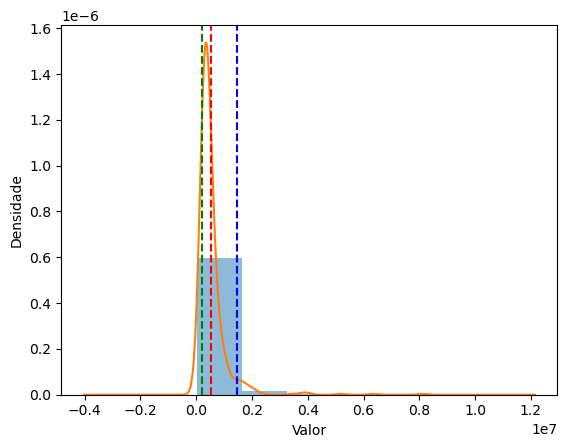

In [26]:
# Plotar o histograma e o gráfico de densidade
train_trat_v1['Applicant_Income'].plot.hist(density=True, bins=5, alpha=0.5)
train_trat_v1['Applicant_Income'].plot.kde()

mean = train_trat_v1['Applicant_Income'].mean()
q5 = train_trat_v1['Applicant_Income'].quantile(0.05)
q95 = train_trat_v1['Applicant_Income'].quantile(0.95)

plt.axvline(mean, color='red', linestyle='--', label='Média')
plt.axvline(q5, color='green', linestyle='--', label='P5')
plt.axvline(q95, color='blue', linestyle='--', label='P95')

plt.xlabel('Valor')
plt.ylabel('Densidade')

plt.show()

In [27]:
# Calcular o coeficiente de assimetria de Fisher
coef_assimetria = train_trat_v1['Applicant_Income'].skew().round(2)
print(coef_assimetria)

#Valor próximo a zero : indica uma distribuição aproximadamente simétrica.
#Valor positivo : indica uma assimetria à direita, com a cauda longa à direita da média.
#Valor negativo : indica uma assimetria à esquerda, com a cauda longa à esquerda da média.
#Quanto maior o valor absoluto do coeficiente, maior é a magnitude da assimetria.

6.54


In [28]:
# Calcular o coeficiente de curtose de Fisher
coef_curtose = train_trat_v1['Applicant_Income'].kurtosis().round(2)
print(coef_curtose)

#Valor próximo a zero : indica uma distribuição aproximadamente normal.
#Valor positivo : indica uma distribuição mais concentrada, com caudas pesadas e picos mais altos.
#Valor negativo : indica uma distribuição menos concentrada, com caudas leves e picos mais baixos.
#Quanto maior o valor absoluto da curtose, mais diferente é a distribuição em relação à distribuição normal.

60.54


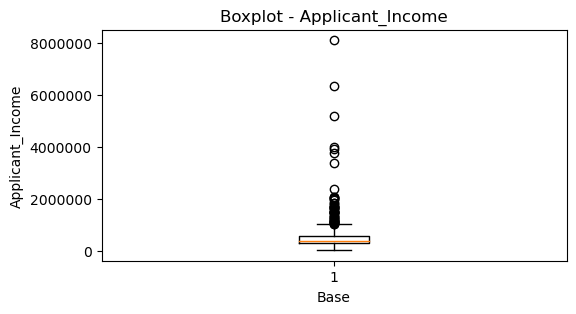

In [29]:
# Gráfico de boxplot para a base como um todo
plt.figure(figsize=(6, 3))
plt.boxplot(train_trat_v1['Applicant_Income'])
plt.title('Boxplot - Applicant_Income')
plt.xlabel('Base')
plt.ylabel('Applicant_Income')

# Configurar formato dos rótulos do eixo Y para a forma padrão
plt.ticklabel_format(style='plain', axis='y')

plt.show()

<Figure size 800x600 with 0 Axes>

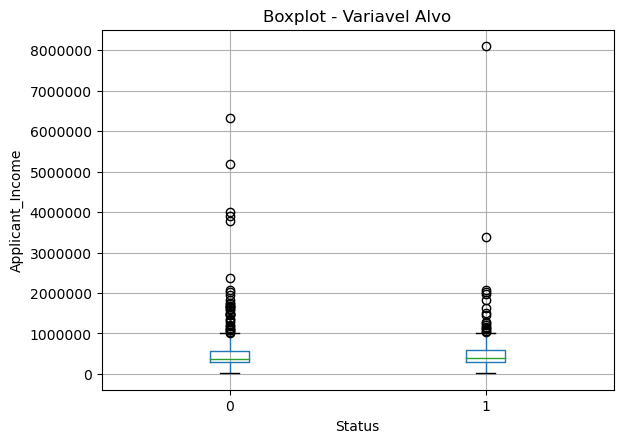

In [30]:
# Gráfico de boxplot para cada grupo separadamente
plt.figure(figsize=(8, 6))
train_trat_v1.boxplot(column='Applicant_Income', by='Status')
plt.title('Boxplot - Variavel Alvo')
plt.xlabel('Status')
plt.ylabel('Applicant_Income')
plt.suptitle('')  # Remover título automático

# Configurar formato dos rótulos do eixo Y para a forma padrão
plt.ticklabel_format(style='plain', axis='y')

plt.show()

- Variável : Coapplicant Income

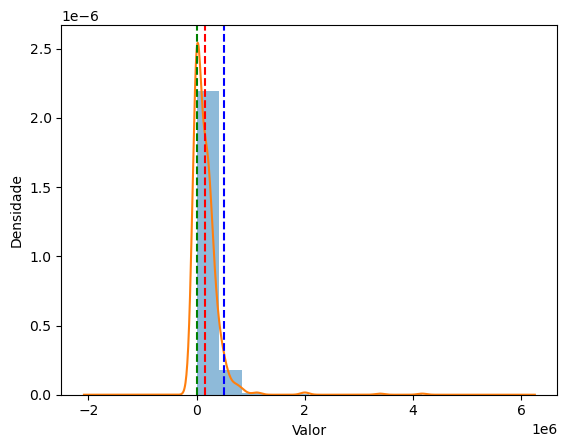

In [31]:
# Plotar o histograma e o gráfico de densidade
train_trat_v1['Coapplicant_Income'].plot.hist(density=True, bins=10, alpha=0.5)
train_trat_v1['Coapplicant_Income'].plot.kde()

mean = train_trat_v1['Coapplicant_Income'].mean()
q5 = train_trat_v1['Coapplicant_Income'].quantile(0.05)
q95 = train_trat_v1['Coapplicant_Income'].quantile(0.95)

plt.axvline(mean, color='red', linestyle='--', label='Média')
plt.axvline(q5, color='green', linestyle='--', label='P5')
plt.axvline(q95, color='blue', linestyle='--', label='P95')

plt.xlabel('Valor')
plt.ylabel('Densidade')

plt.show()

In [32]:
coef_assimetria = train_trat_v1['Coapplicant_Income'].skew().round(2)
coef_curtose = train_trat_v1['Coapplicant_Income'].kurtosis().round(2)
print("Assimetria : ", coef_assimetria)
print("Curtose : ",coef_curtose)

Assimetria :  7.49
Curtose :  84.96


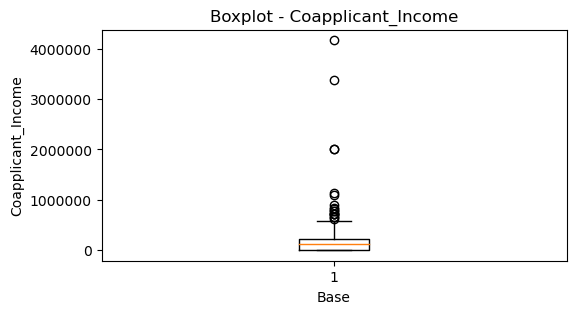

In [33]:
# Gráfico de boxplot para a base como um todo
plt.figure(figsize=(6, 3))
plt.boxplot(train_trat_v1['Coapplicant_Income'])
plt.title('Boxplot - Coapplicant_Income')
plt.xlabel('Base')
plt.ylabel('Coapplicant_Income')

# Configurar formato dos rótulos do eixo Y para a forma padrão
plt.ticklabel_format(style='plain', axis='y')

plt.show()

<Figure size 800x600 with 0 Axes>

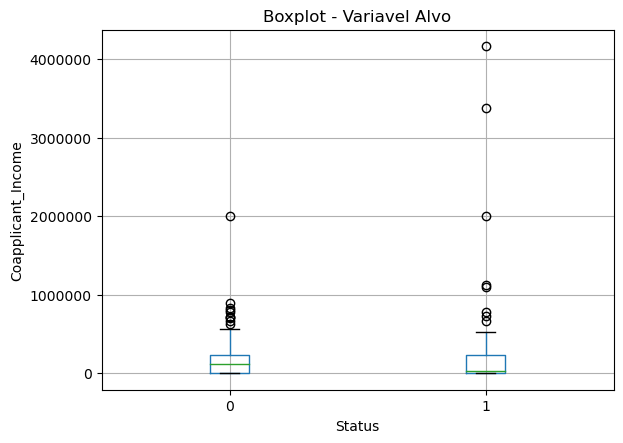

In [34]:
# Gráfico de boxplot para cada grupo separadamente
plt.figure(figsize=(8, 6))
train_trat_v1.boxplot(column='Coapplicant_Income', by='Status')
plt.title('Boxplot - Variavel Alvo')
plt.xlabel('Status')
plt.ylabel('Coapplicant_Income')
plt.suptitle('')  # Remover título automático

# Configurar formato dos rótulos do eixo Y para a forma padrão
plt.ticklabel_format(style='plain', axis='y')

plt.show()

- Variável : Loan_Amount

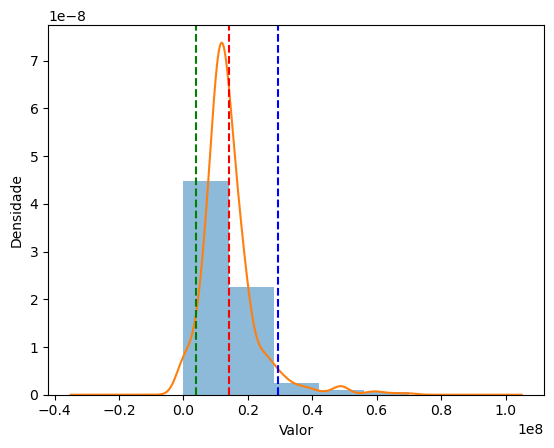

In [35]:
# Plotar o histograma e o gráfico de densidade
train_trat_v1['Loan_Amount'].plot.hist(density=True, bins=5, alpha=0.5)
train_trat_v1['Loan_Amount'].plot.kde()

mean = train_trat_v1['Loan_Amount'].mean()
q5 = train_trat_v1['Loan_Amount'].quantile(0.05)
q95 = train_trat_v1['Loan_Amount'].quantile(0.95)

plt.axvline(mean, color='red', linestyle='--', label='Média')
plt.axvline(q5, color='green', linestyle='--', label='P5')
plt.axvline(q95, color='blue', linestyle='--', label='P95')

plt.xlabel('Valor')
plt.ylabel('Densidade')

plt.show()

In [36]:
coef_assimetria = train_trat_v1['Loan_Amount'].skew().round(2)
coef_curtose = train_trat_v1['Loan_Amount'].kurtosis().round(2)
print("Assimetria : ", coef_assimetria)
print("Curtose : ",coef_curtose)

Assimetria :  2.38
Curtose :  9.26


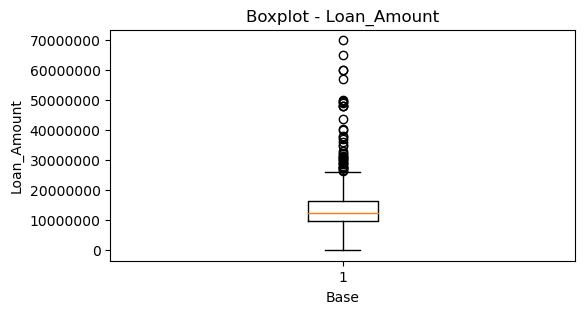

In [37]:
# Gráfico de boxplot para a base como um todo
plt.figure(figsize=(6, 3))
plt.boxplot(train_trat_v1['Loan_Amount'])
plt.title('Boxplot - Loan_Amount')
plt.xlabel('Base')
plt.ylabel('Loan_Amount')

# Configurar formato dos rótulos do eixo Y para a forma padrão
plt.ticklabel_format(style='plain', axis='y')

plt.show()

<Figure size 800x600 with 0 Axes>

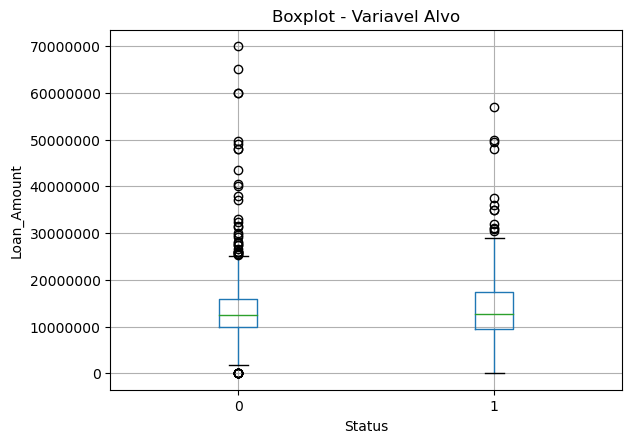

In [38]:
# Gráfico de boxplot para cada grupo separadamente
plt.figure(figsize=(8, 6))
train_trat_v1.boxplot(column='Loan_Amount', by='Status')
plt.title('Boxplot - Variavel Alvo')
plt.xlabel('Status')
plt.ylabel('Loan_Amount')
plt.suptitle('')  # Remover título automático

# Configurar formato dos rótulos do eixo Y para a forma padrão
plt.ticklabel_format(style='plain', axis='y')

plt.show()

# Associação Qui-Quadrado + Magnitude : Married x variavel alvo
- Pergunta : Há associação estatística entre as variáveis ?

     - H0: as variáveis se associam de forma aleatória.
     - H1: a associação entre as variáveis não se dá de forma aleatória.

In [39]:
contingency_married = pd.crosstab(train_trat_v1['Married'], train_trat_v1['Status'])
contingency_married

Status,0,1
Married,,
-1,3,0
0,134,79
1,285,113


In [40]:
# Realizar o teste qui-quadrado
chi2, p_value, _, _ = chi2_contingency(contingency_married)

print("Estatística Qui-Quadrado:", chi2)
print("Valor P:", p_value)

#P-valor = 0.4, ou seja, dado o nível de significância de 0.5, há evidências estatísticas para rejeitar a hipótese nula de que as duas variáveis são independentes. 

Estatística Qui-Quadrado: 6.25486591304784
Valor P: 0.04383016690616309


In [41]:
# Calcular o coeficiente de contingência (Cramér's V)

n = contingency_married.sum().sum()
#calcular a soma total dos valores em uma tabela de contingência

v = (chi2 / n) ** 0.5
# Divide o valor do qui-quadrado (chi2) pelo valor de n, que representa a soma total dos valores na tabela de contingência. O resultado dessa divisão é a estatística do qui-quadrado padronizada.
# O operador ** é usado para elevar o resultado dessa divisão a 0.5. Essa etapa é realizada para calcular a raiz quadrada do valor.
# O resultado dessa operação é atribuído à variável v, que representa o coeficiente de contingência (Cramér's V).


print('Coeficiente de contingência (Cramér\'s V):', v.round(3))
#Quanto mais próximo o valor de V estiver de 0, menor será a associação entre as variáveis, e quanto mais próximo de 1, maior será a associação.

Coeficiente de contingência (Cramér's V): 0.101


- Resultado : Há associação siginificativa sim, porém, com baixa magnitude.

# Associação Qui-Quadrado + Magnitude : Dependents x variavel alvo

In [42]:
contingency = pd.crosstab(train_trat_v1['Dependents'], train_trat_v1['Status'])
chi2, p_value, _, _ = chi2_contingency(contingency)

print("Estatística Qui-Quadrado:", chi2.round(3))
print("Valor P:", p_value.round(3))

Estatística Qui-Quadrado: 3.158
Valor P: 0.368


In [43]:
# Calcule o Índice de Tschuprow - Ele é usual para as qualitivas ordinarias, com ele podemos ver associação negativa ou positiva, assim como a correlação, que varia entre -1 e 1.
tschuprow = (contingency.values.max() - contingency.values.min()) / contingency.sum().sum()
print("Índice de Tschuprow:", tschuprow.round(3))

Índice de Tschuprow: 0.367


In [44]:
type(tschuprow)

numpy.float64

- Resultado : Não há associação siginificativa entre essas variáveis (P-valor = 0.3)

# Associação Qui-Quadrado + Magnitude : Credit_History x variavel alvo

In [45]:
contingency = pd.crosstab(train_trat_v1['Credit_History'], train_trat_v1['Status'])
chi2, p_value, _, _ = chi2_contingency(contingency)

print("Estatística Qui-Quadrado:", chi2.round(3))
print("Valor P:", p_value, " -> round : ", p_value.round())

Estatística Qui-Quadrado: 174.637
Valor P: 7.184759548750746e-40  -> round :  0.0


In [46]:
# Coeficiente Phi: É uma medida de associação que varia de -1 a 1. É uma versão padronizada do coeficiente de contingência e é usado especificamente para tabelas de contingência 2x2.
phi = math.sqrt(chi2 / contingency.sum().sum())
print("Coeficiente Phi:", round(phi,3))

Coeficiente Phi: 0.556


- Resultado : Pode-se concluir que existe uma grande associação estatisticamente significativa, com magnitude moderada positiva entre as variáveis analisadas.

# Associação Qui-Quadrado + Magnitude : Graduate x variavel alvo

In [47]:
contingency = pd.crosstab(train_trat_v1['Graduate'], train_trat_v1['Status'])
chi2, p_value, _, _ = chi2_contingency(contingency)

print("Estatística Qui-Quadrado:", chi2.round(3))
print("Valor P:", p_value, " -> round : ", p_value.round(4))

Estatística Qui-Quadrado: 4.091
Valor P: 0.04309962129357355  -> round :  0.0431


In [48]:
# Coeficiente Phi: É uma medida de associação que varia de -1 a 1. É uma versão padronizada do coeficiente de contingência e é usado especificamente para tabelas de contingência 2x2.
phi = math.sqrt(chi2 / contingency.sum().sum())
print("Coeficiente Phi:", round(phi,3))

Coeficiente Phi: 0.082


- Resultado : Podemos dizer que há uma associação estatisticamente significativa entre as variáveis, mas essa associação é muito fraca.